In [32]:
import math
import numpy as np
import scipy.special as sp
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from numba import jit,int64,float64
import time
import scipy.optimize as sciopt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [33]:
#Plot template

# fig,ax = plt.subplots(1,1)
# ax.scatter(alphas_arr,stabilities_arr[:,0],c=CB_color_cycle[0],marker=">",label="fate 1")
# ax.scatter(alphas_arr,stabilities_arr[:,1],c=CB_color_cycle[1],marker="<",label="fate 2",alpha=1)
# ax.axhline(y=stability_thresh,c="k",ls="--",label="threshold")
# ax.tick_params(axis='both', which='major', labelsize=12)
# ax.tick_params(axis='both', which='minor', labelsize=10)
# ax.set_xlabel(r"Noise coefficient $\alpha$",fontsize=18)
# ax.set_ylabel(r"Mean stability factor",fontsize=18)
# ax.legend(loc="best",fontsize=12)
# ax.set_title(f"Stability vs. noise",fontsize=20)
# fig.savefig("1b_stability_vs_noise.svg",format="svg")

#Color-blind friendly colors to plot:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [26]:
#Parameters - self-activation a, cross-repression r, decay k, noise alpha:
a = np.array([0,0])
r = np.array([1,1])
k = np.array([1,1])
alpha = np.array([0.1,0.1])
#Hill coefficients:
n = np.array([[4,4],[4,4]])
theta = np.array([[0.5,0.5],[0.5,0.5]])

#The total time and dt::
T = 20
dt = 0.005
#Other time-related variables related to these two:
Nt = int(T/dt)
sqrt_dt = np.sqrt(dt)
TimeRange = np.arange(0,T,dt)
# #This is to calculate the dynamic threshold moving average:
# timeBase = 2*int(Nt/100)
# #Time to plot utility against:
# time_trunc = TimeRange[int((timeBase/2)-1):-int(timeBase/2)]

#Let's call num_traj the number of trajectories:
num_traj = 10000

#The initial conditions:
x0 = np.zeros((2,num_traj))
#Uniform around mean:
init_bias = 0
x0[0,:] = init_bias*np.ones(num_traj)

#The threshold above which we say x_i is high:
thresh = [0.7,0.7]

#Color-blind friendly colors to plot:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [27]:
#Self-activation:
@jit(nopython=True)
def activation(x,a,n,theta):
    if (x>=0):
        return (a*x**n)/(x**n + theta**n)
    else:
        return 0

#Cross-inhibition
@jit(nopython=True)
def repression(x,r,n,theta):
    if (x>0):
        return (r*theta**n)/(x**n + theta**n)
    else:
        return 0

#Bias (for external signals):
@jit(nopython=True)
def ext_bias(x1,x2,t):
#     return (x1-x2,x2-x1)
    temp = 0
    return (temp,0)
    
#This solves the system fwd using simple Euler-Maruyama:
@jit(nopython=True)
def Solver(initial,a,r,k,n,theta,alpha):
    final = np.empty((2,num_traj,Nt))
    final[:,:,0] = initial
    #Solving the system forward in time:
    for i in range(num_traj):
        for t in range(1,Nt):
            #Equation for first species:
            temp = np.sqrt(np.maximum(final[0,i,t-1],0.01))
            noise = rand.normalvariate(0,alpha[0]*temp)
            final[0,i,t] = final[0,i,t-1] + dt*(activation(final[0,i,t-1],a[0],n[0,0],theta[0,0]) \
                                               + repression(final[1,i,t-1],r[0],n[1,0],theta[1,0]) \
                                               - k[0]*final[0,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[0]) \
                                                + sqrt_dt*noise
            #Equation for second:
            temp = np.sqrt(np.maximum(final[1,i,t-1],0.01))
            noise = rand.normalvariate(0,alpha[1]*temp)
            final[1,i,t] = final[1,i,t-1] + dt*(activation(final[1,i,t-1],a[1],n[1,1],theta[1,1]) \
                                               + repression(final[0,i,t-1],r[1],n[0,1],theta[0,1]) \
                                               - k[1]*final[1,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[1]) \
                                                + sqrt_dt*noise
    return final

In [28]:
#Generating some trajectories:
start_time = time.time()
traj_simple = np.empty((2,num_traj,Nt))
traj_simple = Solver(x0,a,r,k,n,theta,alpha)
end_time = time.time()
loop_time = end_time - start_time
print(f"Time taken: {loop_time} s.")

Time taken: 6.832901477813721 s.


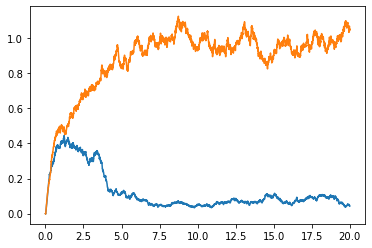

In [29]:
plt.plot(TimeRange,traj_simple[0,0,:])
plt.plot(TimeRange,traj_simple[1,0,:])

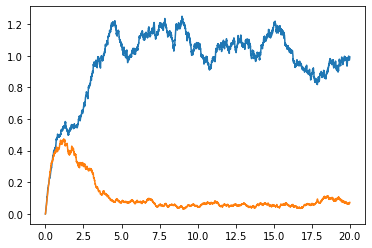

In [30]:
plt.plot(TimeRange,traj_simple[0,1,:])
plt.plot(TimeRange,traj_simple[1,1,:])

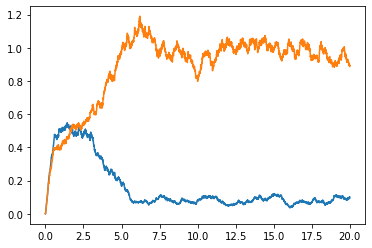

In [31]:
plt.plot(TimeRange,traj_simple[0,2,:])
plt.plot(TimeRange,traj_simple[1,2,:])